### Install Packages

First, we begin from loading packages.

In [1]:
library(grid)
library(lattice) 

To access the overall package documentation, type

In [2]:
#library(ChainLadder)

In [3]:
#demo(package="ChainLadder")

In [4]:
#vignette('ChainLadder', package='ChainLadder')

### Development Triangle

Reading the given dataset into R.

In [5]:
rawdata <- read.csv("datasets/ppauto_pos.csv")
tail(rawdata)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_B,CumPaidLoss_B,BulkLoss_B,EarnedPremDIR_B,EarnedPremCeded_B,EarnedPremNet_B,Single,PostedReserve97_B
14595,43494,American Hallmark Ins Co Of TX,1997,2001,5,5587,5537,0,32271,22646,9625,1,4527
14596,43494,American Hallmark Ins Co Of TX,1997,2002,6,5588,5549,0,32271,22646,9625,1,4527
14597,43494,American Hallmark Ins Co Of TX,1997,2003,7,5571,5567,0,32271,22646,9625,1,4527
14598,43494,American Hallmark Ins Co Of TX,1997,2004,8,5577,5577,0,32271,22646,9625,1,4527
14599,43494,American Hallmark Ins Co Of TX,1997,2005,9,5576,5576,0,32271,22646,9625,1,4527
14600,43494,American Hallmark Ins Co Of TX,1997,2006,10,5573,5576,-3,32271,22646,9625,1,4527


Instead of having the data separated by insurance company, we will sum the data subsets of the cumulative paid losses; then we will arrange the information by accident year and development lag.

In [6]:
.allisnumeric <- function (x, what = c("test", "vector"), extras = c(".", "NA")){
    
  # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  what <- match.arg(what)
  x <- sub("[[:space:]]+$", "", x)
  x <- sub("^[[:space:]]+", "", x)
  #xs <- x[x %nin% c("", extras)]
  xs <- x[match(x, extras, nomatch = 0) == 0]
  isnum <- suppressWarnings(!any(is.na(as.numeric(xs))))
  if (what == "test")
    isnum
  else if (isnum)
    as.numeric(x)
  else x
}

In [7]:
incr2cum <- function(Triangle, na.rm=FALSE){
    
  if(na.rm){
    upper <- col(Triangle) <= ncol(Triangle) + 1 - row(Triangle)
    upperna <- which(is.na(Triangle[upper]), arr.ind=TRUE)
    Triangle[upper][upperna] <- 0
  }
  cum <- t(apply(Triangle,1, cumsum))
  dimnames(cum) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(cum,"exposure") <- expos
  class(cum) <- c("triangle", "matrix")
  cum
}

In [8]:
cum2incr <- function(Triangle){
  incr <- cbind(Triangle[,1], t(apply(Triangle,1,diff)))
  dimnames(incr) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(incr,"exposure") <- expos
  class(incr) <- c("triangle", "matrix")
  incr
}

In [9]:
as.triangle <- function(Triangle, origin="origin", dev="dev", value="value",...){
  UseMethod("as.triangle")
}

In [10]:
as.triangle.matrix <- function(Triangle, origin="origin", dev="dev", value="value",...){
    
  class(Triangle) <- c("triangle", "matrix")
  if(is.null(dimnames(Triangle))){
    dimnames(Triangle) <- list(origin=1:nrow(Triangle), dev=1:ncol(Triangle))
  }
  names(dimnames(Triangle)) <- c(origin, dev)

  if(is.null(dimnames(Triangle)[[origin]])){
    dimnames(Triangle)[[origin]] <- 1:nrow(Triangle)
  }
  if(is.null(dimnames(Triangle)[[dev]])){
    dimnames(Triangle)[[dev]] <- 1:ncol(Triangle)
  }
  storage.mode(Triangle) <- "double"
  return(Triangle)
}

In [11]:
as.triangle.data.frame <- function(Triangle, origin="origin", dev="dev", value="value", ...){
  
  # aggregate claims data
  aggTriangle <- stats::aggregate(Triangle[[value]], list(Triangle[[dev]], Triangle[[origin]]), sum)
  names(aggTriangle) <- c(dev, origin, value)
  origin_names <- as.character(unique(aggTriangle[, origin]))
  dev_names <-  as.character(unique(aggTriangle[, dev]))
  
  # reshape into wide format
  tria <- stats::reshape(aggTriangle, 
                  v.names=value, 
                  timevar = dev, 
                  idvar = origin, 
                  direction = "wide", 
                  new.row.names = origin_names)[, -1]
  
  matrixTriangle <- as.matrix(tria)
  names(dimnames(matrixTriangle)) <- c(origin, dev)
  dimnames(matrixTriangle)[[1]] <- origin_names
  dimnames(matrixTriangle)[[2]] <- dev_names
  matrixTriangle <- matrixTriangle[order(nchar(origin_names), origin_names), order(nchar(dev_names), dev_names)]
  class(matrixTriangle) <- c("triangle", "matrix")
  return(matrixTriangle)
}

In [12]:
triangle <- function(..., bycol = FALSE, origin = "origin", dev = "dev", value = "value"){
    
  x <- list(...)
  if (length(x) == 1L) {
    ## 'len' contains the number of development periods (when filling by row) or origin periods (when filling by column). In the case
    ## where there is only one vector of data provided, 'len' is the positive root of n(n + 1)/2 = k, where k is the number of data
    ## points.
    len <- (-1 + sqrt(1 + 8 * length(x[[1L]])))/2
    ## Error if 'len' is not an integer, otherwise it is just too complicated to try infer what user wants. (Test taken from ?is.integer.)
    if (abs(len - round(len)) > .Machine$double.eps^0.5)
        stop("invalid number of data points for a triangle")
    ## Rearrange the data vector in a list of vectors suitable to build a 'len x len' triangle.
    s <- seq_len(len)                   # avoid generating twice
    x <- split(x[[1L]], rep(s, rev(s)))
  } else {
    ## If more than one data vector is provided in argument, the number of development or origin periods is derived from the
    ## *first* vector (this avoids looking at the length of each and every element to find the maximum).
    len <- length(x[[1L]])
  }
  ## Extend each data vector to length 'len' by filling with NAs and put into matrix form at the same time; dimension names will be in
  ## place thanks to 'sapply'.
  x <- sapply(x, function(x) { length(x) <- len; x })
  ## Turn to 'as.triangle' to complete the work.
  as.triangle.matrix(if (bycol) x else t(x), origin = origin, dev = dev, value = value)
}

In [13]:
as.data.frame.triangle <- function(x, row.names=NULL, optional, lob=NULL, na.rm=FALSE,...){

  longTriangle <- .as.LongTriangle(x, na.rm)
  if(is.null(row.names))
    rownames(longTriangle) <- paste(longTriangle[,1], longTriangle[,2], sep="-")
  if(!is.null(lob))
    longTriangle$lob=lob

  class(longTriangle) <- c("long.triangle", "data.frame")
  return(longTriangle)
}

plot.triangle <- function(x,type="b", xlab="dev. period", ylab=NULL, lattice=FALSE,...){
  .x <- x
  class(.x) <- "matrix"
  if(!lattice){
    matplot(t(.x),type=type, xlab=xlab, ylab=ifelse(is.null(ylab), deparse(substitute(x)), ylab),...)
  }else{
    df <- as.data.frame(as.triangle(.x)) 
    xyplot(value ~ dev | factor(origin), data=df, type=type, as.table=TRUE, xlab=xlab, ylab=ylab, ...)
  }
}

In [14]:
print.triangle <- function(x, ...) {
  ret <- x
  class(x) <- tail(class(x), -1)
  NextMethod(x, ...)
  invisible(ret)
}

In [15]:
.as.MatrixTriangle <- function(x, origin="origin", dev="dev", value="value"){
    
  ## x has to be a data.frame with columns: origin, dev and value
  x <- x[,c(origin, dev, value)]
  names(x) <- c("origin", "dev", "value")
  z <- reshape(x, timevar="dev", v.names="value", idvar="origin", direction="wide")
  z <- z[order(z$origin), ]

  .origin.names <- z$origin
  z <- z[,-1]
  names(z) <- gsub("value.", "",names(z))
  .dev.names <- as.numeric(as.character(names(z)))
  z <- z[,order(.dev.names)]

  z<- as.matrix(z)
  dimnames(z) <- list(origin=.origin.names, dev=sort(.dev.names))
  names(dimnames(z)) <- c(origin, dev)
  return(z)
}

In [16]:
as.LongTriangle <- function (Triangle, varnames = names(dimnames(Triangle)), value.name = "value", na.rm = TRUE) {
    
  if (!inherits(Triangle, "matrix")) stop("asLongTriangle only works for matrices")
  if (is.null(varnames)) varnames <- c("origin", "dev")
  else {
    if (is.na(varnames[1L])) varnames[1L] <- "origin"
    if (is.na(varnames[2L])) varnames[2L] <- "dev"
  }
  namecols <- setNames(expand.grid(dimnames(Triangle), KEEP.OUT.ATTRS = FALSE, stringsAsFactors = TRUE), varnames)
  if (na.rm) {
    isna <- is.na(Triangle)
    namecols <- namecols[!isna,]
    Triangle <- Triangle[!isna]
  }
  y <- cbind(namecols, setNames(data.frame(c(Triangle)), value.name))
  y
}

In [17]:
.as.LongTriangle <- function(Triangle, na.rm=FALSE){
    
  x <- Triangle
  nms <- names(dimnames(x))
  .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  .origin <- dimnames(x)[[nms[1L]]]
  if(class(dimnames(x)[[nms[2L]]]) %in% "character"){
    if(.allisnumeric(dimnames(x)[[nms[2L]]])){
      .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
    }else{
      .dev <- seq(along=(dimnames(x)[[nms[2L]]]))
      warning(paste(
        c("Development period was a character and has been set to:\n",.dev),
        collapse = " "))
    }
  }else{
    .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  }
  lx <- expand.grid(origin=.origin, dev=.dev, stringsAsFactors = FALSE)
  lx$value <- as.vector(x)
  if(na.rm){
    lx <- na.omit(lx)
  }
  if (!is.null(nms)) {
    if (!is.na(nms[1L])) names(lx)[1L] <- nms[1L]
    if (!is.na(nms[2L])) names(lx)[2L] <- nms[2L]
  }
  return(lx)
}

In [18]:
# A coefficients method to quickly pull out the factors from a ChainLadder model
coef.ChainLadder <- function(object, ...) {
  structure(sapply(object$Models, coefficients), names = head(colnames(object$Triangle), -1), ...)
}

In [19]:
getLatestCumulative <- function (Triangle, na.values = NULL) {
  # Returns the "current diagonal" from a triangle. This is defined to be the vector of entries from the triangle corresponding 
  # to the rightmost non-missing cell per row.
  # Features: 
  # 1. For the "lazy actuary" who leaves zeroes in triangle cells corresponding to future observations, can specify 
  #     na.values=0 to find the rightmost non-zero and non-NA entry.
  # 2. Assigns a "latestcol" attribute that gives the column index of the rightmost entry per row.
  # 3. Adorns the returned vector with 'names' corresponding to the rownames of the triangle, if available, and with a 'rowsname' 
  #    attribute holding the name of the row dimension of the matrix (e.g., 'origin' or 'ay'), if available.
  # 4. Assigns a 'colnames' attribute holding the column names of the matrix, if available, and with a "colsname" attribute holding 
  #    the name of the column dimension of the matrix  (e.g., 'dev' or 'age'), if available.
  #    The attributes assigned in 3 & 4 can be useful when the current diagonal is utilized in a method that may be unrelated to 
  #    the given Triangle but that relies on the origin and development age of the observations in the diagonal.
  
  if (!is.matrix(Triangle)) stop("Triangle '", 
      deparse(substitute(Triangle)), "' must be a matrix")
  # Define a function that, depending on the value of na.values, finds the rightmost column per row.
  f <- if (is.null(na.values)) function(x) ifelse(length(w <- which(!is.na(x))) > 0L, tail(w, 1L), 1) else function(x) ifelse(length(w <- which(!is.na(x) & !(x %in% na.values))) > 0L, tail(w, 1L), 1)
  # Apply that function to each row.
  latestcol <- apply(Triangle, 1L, f)
  # Select the rightmost values
  latestdiag <- Triangle[cbind(seq_along(latestcol), latestcol)]
  # Set attributes ...
  attr(latestdiag, "latestcol") <- latestcol
  # Set names and colnames attributes
  nms <- names(dmnms <- dimnames(Triangle))
  nms1 <- nms[1L]
  nms2 <- nms[2L]
  if (!is.null(dmnms[[1L]])) { # 'rownames' are available
    names(latestdiag) <- dmnms[[1L]]
    # save the name of the row dimension
    attr(latestdiag, "rowsname") <- nms1
    }
  if (!is.null(dmnms[[2L]])) { # 'colnames' are available
    attr(latestdiag, "colnames") <- dmnms[[2L]][latestcol]
    # save the name of the column dimension
    attr(latestdiag, "colsname") <- nms2
    }
  return(latestdiag)
  }

To make it to be a loss triangle, we will exclude any developments after 1997 in the dataset; then we will use the function, as.triangle, to organize the data into triangle format.

In [20]:
sumdata <- rawdata[rawdata$DevelopmentYear < 1998,]
ppauto <- as.triangle(sumdata, origin = "AccidentYear", dev = "DevelopmentLag", value = "CumPaidLoss_B")
ppauto

,1,2,3,4,5,6,7,8,9,10
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,NA
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,NA,NA
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,NA,NA,NA
1992,4551591,8344021,10047179,10901995,11336777,11555121,NA,NA,NA,NA
1993,5020277,9125734,10890282,11782219,12249826,NA,NA,NA,NA,NA
1994,5569355,9871002,11641397,12600432,NA,NA,NA,NA,NA,NA
1995,5803124,10008734,11807279,NA,NA,NA,NA,NA,NA,NA
1996,5835368,9900842,NA,NA,NA,NA,NA,NA,NA,NA
1997,5754249,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Chain-Ladder Functions

In [21]:
chainladder <- function(Triangle, weights=1, delta=1){

    Triangle <- checkTriangle(Triangle)
    n <- dim(Triangle)[2]

    ## Mack uses alpha between 0 and 2 to distinguish
    ## alpha = 0 straight averages
    ## alpha = 1 historical chain ladder age-to-age factors
    ## alpha = 2 ordinary regression with intercept 0
    ## However, in Zehnwirth & Barnett they use the notation of delta, whereby delta = 2 - alpha
    ## the delta is than used in a linear modelling context.
    weights <- checkWeights(weights, Triangle)
    delta <- rep(delta,(n-1))[1:(n-1)]

    lmCL <- function(i, Triangle){
      lm(y~x+0, weights=weights[,i]/Triangle[,i]^delta[i],
         data=data.frame(x=Triangle[,i], y=Triangle[,i+1]))
    } 
    myModel <- lapply(c(1:(n-1)), lmCL, Triangle)
    output <- list(Models=myModel, Triangle=Triangle, delta=delta, weights=weights)
    class(output) <- c("ChainLadder", "TriangleModel", class(output))
    return(output)
}

In [22]:
checkWeights <- function(weights, Triangle){

    if(is.null(dim(weights))){
        if(length(weights)==1){
            my.weights <- Triangle
            my.weights[!is.na(Triangle)] <- weights
            weights <- my.weights
        }
    }
return(weights)
}

In [23]:
predict.TriangleModel <- function(object,...){

  n <- ncol(object[["Triangle"]])
  FullTriangle <- object[["Triangle"]]
  MF <- lapply(c(2:n), 
               function(j){
                 ii <- is.na(FullTriangle[,j])
                 FF <- predict(object[["Models"]][[j-1]], se.fit=TRUE, newdata=data.frame(x=FullTriangle[ii, j-1]))
                 FullTriangle[ii,j] <<- FF$fit
                 return(FF)
               }             
               )
    return(list(FullTriangle=FullTriangle, Prediction=MF))
}

In [24]:
predict.ChainLadder <- function(object,...){
  res <- predict.TriangleModel(object,...)
  res[["FullTriangle"]]
}

In [25]:
## estimate tail factor, idea from Thomas Mack:
## THE STANDARD ERROR OF CHAIN LADDER RESERVE ESTIMATES: RECURSIVE CALCULATION AND INCLUSION OF A TAIL FACTOR

tailfactor <- function (clratios){
    f <- clratios
    n <- length(f)
    if (f[n - 2] * f[n - 1] > 1.0001) {
        fn <- which(clratios > 1)
        f <- clratios[fn]
        n <- max(fn)
        tail.model <- lm(log(f - 1) ~ fn)
        co <- coef(tail.model)
        tail <- exp(co[1] + c((n+1):(n + 100)) * co[2]) + 1
        tail <- prod(tail)
        if (tail > 2){
            print("The estimate tail factor was bigger than 2 and has been reset to 1.")
            tail <- 1
        }
    }
    else {
        tail <- 1
        tail.model <- NULL
    }
    return(list(tail.factor=tail, tail.model=tail.model))
}

In [26]:
checkTriangle <- function(Triangle){

    ## if a triangle is an array with 3 dimension convert it into a matrix
    .dim <- dim(Triangle)
    if(length(.dim)>3){
      stop("Your array has too many dimensions.")
    }
    
    n <- .dim[2]
    m <- .dim[1]

    if(n>m){
        stop("Number of origin periods, ", m, ", is less than the number of development periods, ", n, ".\n")
    }

    if(length(.dim)==3 & .dim[3]==1){
        dim(Triangle) <- c(m,n)
    }

    if("data.frame" %in% class(Triangle)){
        Triangle <- as.matrix(Triangle)
        Triangle <- as.triangle(Triangle)
        storage.mode(Triangle) <- "double"
    }

    tri.dimnames <- dimnames(Triangle)
    if(is.null(tri.dimnames[[1]])){
        .origin <- 1:m
    }else{
        .origin <- tri.dimnames[[1]]
    }
    if(is.null(tri.dimnames[[2]])){
        .dev <- 1:n
    }else{
        .dev <- tri.dimnames[[2]]
    }

    dimnames(Triangle) <- list(origin=.origin, dev=.dev)

    return(Triangle)
}

### Bootstrap Chain-Ladder Functions

The BootChainLadder function uses a two-stage bootstrapping/simulation approach.

In the first stage an ordinary chain-ladder methods is applied to the cumulative claims triangle. From this we calculate the scaled Pearson residuals which we bootstrap R times to forecast future incremental claims payments via the standard chain-ladder method.

In the second stage we simulate the process error with the bootstrap value as the mean and using the process distribution assumed. The set of reserves obtained in this way forms the predictive distribution, from which summary statistics such as mean, prediction error or quantiles can be derived.

In [27]:
BootChainLadder <- function(Triangle, R = 999, process.distr=c("gamma", "od.pois")){
  
  if(!'matrix' %in% class(Triangle))
    Triangle <- as.matrix(Triangle)
  
  process.distr <- match.arg(process.distr)
  weights <- 1/Triangle
  
  triangle <- Triangle
  if(nrow(triangle) != ncol(triangle))
    stop("Number of origin periods has to be equal or greater then the number of development periods.\n")
  
  triangle <- checkTriangle(Triangle)
  output.triangle <- triangle
  
  m <- dim(triangle)[1]
  n <- dim(triangle)[2]
  origins <- c((m-n+1):m)
  
  ## Obtain the standard chain-ladder development factors from cumulative data.
  triangle <- array(triangle, dim=c(m,n,1))
  weights <-  array(weights, dim=c(m,n,1))
  inc.triangle <- getIncremental(triangle)
  Latest <- getDiagonal(triangle,m)
  
  ## Obtain cumulative fitted values for the past triangle by backwards recursion, starting with the observed cumulative 
  ## paid to date in the latest diagonal
  
  dfs <- getIndivDFs(triangle)
  avDFs <- getAvDFs(dfs, 1/weights)
  ultDFs <- getUltDFs(avDFs)
  ults <- getUltimates(Latest, ultDFs)
  ## Obtain incremental fitted values, m^ ij, for the past triangle by differencing.
  exp.inc.triangle <- getIncremental(getExpected(ults, 1/ultDFs))
  ## exp.inc.triangle[is.na(inc.triangle[,,1])] <- NA
  exp.inc.triangle[is.na(inc.triangle[origins,,1])] <- NA
  ## Calculate the unscaled Pearson residuals for the past triangle using:
  inc.triangle <- inc.triangle[origins,,]
  dim(inc.triangle) <- c(n,n,1)
  unscaled.residuals  <- (inc.triangle - exp.inc.triangle)/sqrt(abs(exp.inc.triangle))
  
  ## Calculate the Pearson scale parameter
  nobs  <- 0.5 * n * (n + 1)
  scale.factor <- (nobs - 2*n+1)
  scale.phi <- sum(unscaled.residuals^2,na.rm=TRUE)/scale.factor
  ## Adjust the Pearson residuals using
  adj.resids <- unscaled.residuals * sqrt(nobs/scale.factor)
  
  ## Sample incremental claims
  ## Resample the adjusted residuals with replacement, creating a new past triangle of residuals.
  
  simClaims <- randomClaims(exp.inc.triangle, adj.resids, R)
  
  ## Fit the standard chain-ladder model to the pseudo-cumulative data.
  ## Project to form a future triangle of cumulative payments.
  ## Perform chain ladder projection
  simCum <- makeCumulative(simClaims)
  simLatest <- getDiagonal(simCum,nrow(simCum))
  simDFs <- getIndivDFs(simCum)
  simWghts <- simCum
  simAvDFs <- getAvDFs(simDFs, simWghts)
  simUltDFs <- getUltDFs(simAvDFs)
  simUlts <- getUltimates(simLatest, simUltDFs)
  ## Get expected future claims
  ## Obtain the corresponding future triangle of incremental payments by differencing, to be used as the mean when simulating 
  ## from the process distribution.
  
  simExp <- getIncremental(getExpected(simUlts, 1/simUltDFs))
  simExp[!is.na(simClaims)] <- NA
  processTriangle <-array(NA,c(n,n,R))
  
  if(process.distr=="gamma")
    processTriangle[!is.na(simExp)] <- sign(simExp[!is.na(simExp)])*rgamma(length(simExp[!is.na(simExp)]), shape=abs(simExp[!is.na(simExp)]/scale.phi), scale=scale.phi)
  
  if(process.distr=="od.pois")
    processTriangle <-  apply(simExp,c(1,2,3), function(x)
      ifelse(is.na(x), NA, sign(x)*rpois.od(1, abs(x), scale.phi)))
  
  processTriangle[is.na(processTriangle)] <- 0
  simExp[is.na(simExp)] <- 0
  
  IBNR.Triangles <- processTriangle
  IBNR <- makeCumulative(IBNR.Triangles)[,n,]
  dim(IBNR)<-c(n,1,R)
  ParamDist <- makeCumulative(simExp)[,n,]
  dim(ParamDist)<-c(n,1,R)
  
  # Generate and process Next Year triangle for one year re-reserving approach (Solvency 2 purpose)
  NYCost<-getNYCost(triangle[origins,,,drop=F],IBNR.Triangles,R)
  NYParamDist<-getNYCost(triangle[origins,,,drop=F],simExp,R)
  
  if(m>n){
    IBNR <- apply(IBNR, 3, function(x) c(rep(0, m-n),x))
    dim(IBNR) <- c(m,1,R)
    
    NYCost <- apply(NYCost, 3, function(x) c(rep(0, m-n),x))
    dim(NYCost) <- c(m,1,R)
    
    ParamDist <- apply(ParamDist, 3, function(x) c(rep(0, m-n),x))
    dim(ParamDist) <- c(m,1,R)
    
    NYParamDist <- apply(NYParamDist, 3, function(x) c(rep(0, m-n),x))
    dim(NYParamDist) <- c(m,1,R)
    
    IBNR.Triangles <- apply(IBNR.Triangles,3, function(x) rbind(matrix(0,m-n,n),x))
    dim(IBNR.Triangles) <- c(m,n,R)
    
    simClaims <- apply(simClaims,3, function(x) rbind(matrix(0,m-n,n),x))
    dim(simClaims) <- c(m,n,R)
  }
  
  IBNR.Totals <- apply(IBNR.Triangles,3,sum)
  
  residuals <- adj.resids
  
  output <- list( call=match.call(expand.dots = FALSE),
                  Triangle=output.triangle,
                  f=as.vector(avDFs),
                  simClaims=simClaims,
                  IBNR.ByOrigin=IBNR,
                  IBNR.Triangles=IBNR.Triangles,
                  IBNR.Totals = IBNR.Totals,
                  ParamDist.ByOrigin=ParamDist,
                  NYCost.ByOrigin = NYCost,
                  NYParamDist.ByOrigin=NYParamDist,
                  #NYIBNR.ByOrigin = NYIBNR,
                  ChainLadder.Residuals=residuals,
                  process.distr=process.distr,
                  R=R)
  
  class(output) <- c("BootChainLadder", class(output))
  return(output)
}

In [28]:
## residuals.BootChainLadder

residuals.BootChainLadder <- function(object,...){
  return(object$ChainLadder.Residuals)
}

In [29]:
## quantile.BootChainLadder

quantile.BootChainLadder <- function(x,probs=c(0.75, 0.95), na.rm = FALSE, names = TRUE, type = 7,...){
  
  m <- dim(x$Triangle)[1]
  n <- dim(x$Triangle)[2]
  
  ByOrigin <- t(apply(x$IBNR.ByOrigin, 1, quantile, probs=probs, names=names, type=type,...))
  
  if(length(probs)>1){
    ByOrigin <- as.data.frame(ByOrigin)
  }else{
    ByOrigin <- as.data.frame(t(ByOrigin))
  }
  names(ByOrigin) <- paste("IBNR ", probs*100, "%", sep="")
  
  origin <- dimnames(x$Triangle)[[1]]
  
  if(length(origin)==nrow(ByOrigin)){
    rownames(ByOrigin) <- origin
  }
  
  Total.IBNR.q <- quantile(x$IBNR.Totals, probs=probs, names=names, type=type, ...)
  
  Totals <- as.data.frame(Total.IBNR.q)
  
  colnames(Totals)=c("Totals")
  rownames(Totals) <- paste("IBNR ", probs*100, "%:", sep="")
  
  output <- list(ByOrigin=ByOrigin, Totals=Totals)
  
  return(output)
}

In [30]:
## mean.BootChainLadder

mean.BootChainLadder <- function(x,...){
  
  m <- dim(x$Triangle)[1]
  n <- dim(x$Triangle)[2]
  
  ByOrigin <- apply(x$IBNR.ByOrigin, 1, mean,...)
  ByOrigin <- as.data.frame(ByOrigin)
  names(ByOrigin) <- "Mean IBNR"
  
  origin <- dimnames(x$Triangle)[[1]]
  if(length(origin)==nrow(ByOrigin)){
    rownames(ByOrigin) <- origin
  }
  
  Total.IBNR <- mean(x$IBNR.Totals,...)
  Totals <- as.data.frame(Total.IBNR)
  
  colnames(Totals)=c("Total")
  rownames(Totals) <- "Mean IBNR:"
  
  output <- list(ByOrigin=ByOrigin, Totals=Totals)
  return(output)
}

In [31]:
## summary.BootChainLadder

summary.BootChainLadder <- function(object,probs=c(0.75,0.95),...){
  
  .Triangle <- object$Triangle
  m <- dim(.Triangle)[1]
  n <- dim(.Triangle)[2]
  
  dim(.Triangle) <- c(dim(.Triangle),1)
  Latest <- as.vector(getLatest(getIncremental(.Triangle)))
  
  IBNR <- object$IBNR.ByOrigin
  dim(IBNR) <- dim(IBNR)[c(1,3)]
  IBNR.q <- apply(IBNR, 1, quantile, probs=probs,...)
  IBNR.mean <- apply(IBNR, 1, mean)
  IBNR.sd <- apply(IBNR, 1, sd)
  sumIBNR <- t(rbind(IBNR.mean, IBNR.sd, IBNR.q))
  sumIBNR <- as.data.frame(sumIBNR)
  
  ## ByOrigin
  ByOrigin <- data.frame(Latest, Ult.mean=Latest+sumIBNR$IBNR.mean, sumIBNR)
  names(ByOrigin) <- c("Latest", "Mean Ultimate", "Mean IBNR", "SD IBNR", paste("IBNR ", probs*100, "%", sep=""))
  ex.origin.period <- Latest!=0
  ByOrigin <- ByOrigin[ex.origin.period,]
  
  origin <- dimnames(object$Triangle)[[1]]
  if(length(origin)==nrow(ByOrigin)){
    rownames(ByOrigin) <- origin
  }
  
  ## Totals
  Total.Latest <- sum(Latest,na.rm=TRUE)
  Total.IBNR <- object$IBNR.Totals
  Total.IBNR.mean <-  mean(Total.IBNR)
  Total.IBNR.sd <-  sd(Total.IBNR)
  Total.IBNR.q <- quantile(Total.IBNR, probs=probs,...)
  Totals <-  c(Total.Latest, Total.Latest+Total.IBNR.mean,Total.IBNR.mean, Total.IBNR.sd, Total.IBNR.q)
  Totals <- as.data.frame(Totals)
  
  colnames(Totals)=c("Totals")
  rownames(Totals) <- c("Latest:","Mean Ultimate:", "Mean IBNR:","SD IBNR:", paste("Total IBNR ", probs*100, "%:", sep="") )
  
  output <- list(ByOrigin=ByOrigin, Totals=Totals)
  return(output)
}

In [32]:
## print.BootChainLadder

print.BootChainLadder <- function(x,probs=c(0.75,0.95),...){
  print(x$call)
  cat("\n")
  summary.x <- summary(x,probs=probs)
  
  names(summary.x$ByOrigin)[4] <- "IBNR.S.E"
  print(format(summary.x$ByOrigin, big.mark = ",", digits = 3),...)
  
  cat("\n")
  Totals <- summary.x$Totals
  rownames(Totals)[4] <- "IBNR.S.E"
  print(format(Totals, big.mark=",",digits=3), quote=FALSE)
  
  invisible(x)
}

In [33]:
makeCumulative <- function(tri){
  for (i in 2:dim(tri)[2])
    tri[,i,]<-tri[,i-1,]+tri[,i,]
  return(tri)
}

In [34]:
getIncremental <- function(tri){
  n<-dim(tri)[2]
  tri[,2:n,]<-tri[,2:n,]-tri[,1:(n-1),]
  
  return(tri)
}

In [35]:
getLatest <- function(incr.tri){
  out <- apply(incr.tri, c(1,3), sum, na.rm=T)
  dim(out) <- c(1, dim(out))
  out <- aperm(out, c(2,1,3))
  return(out)
}

In [36]:
getIndivDFs <- function(tri){
  .nDevPrds <- dim(tri)[2]
  .numerator <- tri[ , c(2:.nDevPrds, .nDevPrds), , drop=F]
  tri <- .numerator / tri
  tri[ , .nDevPrds, ] <- NA
  return(tri)
}

In [37]:
getAvDFs <- function(dfs, wghts){
  .include <- dfs
  .include[!is.na(.include)] <- 1
  .include[is.na(wghts)] <- NA
  .include[is.na(.include)] <- 0    
  dfs[is.na(dfs)]<-0
  wghts[is.na(wghts)]<-0
  
  out<-colSums(dfs * wghts * .include)/colSums(wghts * .include)
  out[is.nan(out)] <- 1
  out <- array(out, c(1,dim(out)))
  return(out)
}

In [38]:
getUltDFs <- function(avDFs){
  for (i in seq.int(dim(avDFs)[2]-1,1,-1))
    avDFs[,i,]<-avDFs[,i+1,]*avDFs[,i,]
  return(avDFs)
}

In [39]:
getUltimates <- function(latest, ultDFs){
  m<-dim(ultDFs)[1]
  n<-dim(ultDFs)[2]
  r<-dim(ultDFs)[3]    
  
  ultDFs <- ultDFs[,(dim(ultDFs)[2]):1,]
  dim(ultDFs)<-c(n,1,r)
  out <- latest * ultDFs
  return(out)
}

In [40]:
expandArray <- function(x, d, new.size){
  ## Expand array x, in d th dimension to new.size
  ## Permute dimension to set changing dimension last
  .n <- length(dim(x))
  .perm <- 1:.n
  .perm[d] <- .n
  .perm[.n] <- d
    
  x <- aperm(x, .perm)
  ## Expand dimension
  x <- array(x, dim=c(dim(x)[-.n], new.size))
  ##Return to old dimension arrangement
  x <- aperm(x, .perm)
  return(x)
}

In [41]:
getExpected <- function(ults, ultDFs){
  ## get backward chain ladder incremental triangles
  ults <- expandArray(ults, 2, dim(ultDFs)[2])
  ultDFs <- expandArray(ultDFs, 1, dim(ults)[1])
  return(ults * ultDFs)
}

In [42]:
sampleResiduals <- function(resids, positions, n.sims){
  ## Worry about excluding, zoning, etc. residuals later
  resids <- as.vector(resids)
  resids <- resids[!is.na(resids)]
  .sample <- sample(resids, prod(dim(positions)[-3])*n.sims, replace=T)
  .sample <- array(.sample, dim=c(dim(positions)[-3], n.sims))
  .sample[is.na(positions)] <- NA
  return(.sample)
}

In [43]:
randomClaims <- function(exp.clms, resids, n.sims){
  .residSample <- sampleResiduals(resids, exp.clms, n.sims)
  exp.clms <- expandArray(exp.clms, 3, n.sims)
  out <- .residSample * sqrt(abs(exp.clms)) + exp.clms
  return(out)
}

In [44]:
# functions to generate random numbers following over-dispersed Poisson and negative binomial distributions based on 
# simple cheat of using a standard negative binomial, but choosing the scale parameter to give the desired mean/variance
# ratio at the given value of the mean.

rpois.od<-function (n, lambda,d=1) {
  if (d==1 | lambda<=0)
    rpois(n, lambda)
  else
    rnbinom(n, size=(lambda/(d-1)), mu=lambda)
}

rnbinom.od<-function (n, size, prob, mu, d=1) {
  if (!missing(prob)) {
    if (!missing(mu))
      stop("prob and mu both specified")
    mu<-size*(1-prob)/prob
  }
  size2 <- mu/(d-1+(d*mu/size))
  prob2 <- size2/(size2 + mu)
  rnbinom(n, size2, prob2)
}

In [45]:
## plot.BootChainLadder

plot.BootChainLadder <- function(x, mfrow=NULL, title=NULL, log=FALSE, which=1:4, ...){
    
    if(is.null(title)){ 
      myoma <- c(0,0,0,0) 
    }else{ 
      myoma <- c(0,0,2,0)
    }
    
    Total.IBNR <- x$IBNR.Total
    
    if(is.null(mfrow)){
      mfrow <- c(ifelse(length(which) < 2,1, 
                 ifelse(length(which) < 3, 2, ceiling(length(which)/2))), 
                 ifelse(length(which)>2,2,1))
    }
    
    op=par(mfrow=mfrow, oma=myoma,...)
    
    if(1 %in% which){
      ## Histogram
      hist(Total.IBNR, xlab="Total IBNR")
      lines(density(Total.IBNR))
      rug(Total.IBNR)
    }
    if(2 %in% which){
      ## Empirical distribution
      plot(ecdf(Total.IBNR), xlab="Total IBNR")
    }
    if(3 %in% which){
      ## Plot simultated Ultiamtes by Origin
      plotBootstrapUltimates(x)
    }
    if(4 %in% which){
      ## Backtest last developemt year and check for cal. year trends
      backTest <- backTestLatestIncremental(x)
      plotLatestIncremental(backTest, log=log)
    }
    title( title , outer=TRUE)
    par(op)
  }

In [46]:
backTestLatestIncremental <- function(x){
  if(!any(class(x) %in% "BootChainLadder"))
    stop("This function expects an object of class BootChainLadder")
  
  ## Simulated Latest Incremental
  simLatest <- getLatest(getIncremental(x$simClaims))
  
  ## Actual Latest Incremental
  triangle <- x$Triangle
  dim(triangle) <- c(dim(triangle)[1:2],1)
  actual.incr.Latest <- as.vector(getLatest(getIncremental(getIncremental(triangle))))
  df.actual <- data.frame(actual.incr.Latest, origin=dimnames(x$Triangle)[[1]])
  
  Long.simLatest <- expand.grid(origin=dimnames(x$Triangle)[[1]], sample=c(1:x$R))
  Long.simLatest$sim.incr.Latest <- as.vector(simLatest)
  LongSimActual <- merge(Long.simLatest, df.actual)
  return(LongSimActual)
}

In [47]:
plotLatestIncremental <- function(LongSimActual,##sim.Latest,
                                  ##actual.Latest,
                                  log=TRUE,
                                  xlab="origin period",
                                  ylab="latest incremental claims",
                                  main="Latest actual incremental claims\nagainst simulated values",
                                  col="bisque",
                                  ...){
  ## Plot the latest simulated incremental claims against actual observations to identify calendar year trends
  ## Example:
  ## B <- BootChainLadder(RAA)
  ## x <- backTestLatestIncremental(B)
  ## plotLatestIncremental(x[[1]], x[[1]])
  
  LongSimActual <- LongSimActual[LongSimActual$sim.incr.Latest>0 & LongSimActual$actual.incr.Latest>0,]
  LongSimActual$origin <- factor(LongSimActual$origin)
  if(log){
    boxplot(LongSimActual$sim.incr.Latest ~ LongSimActual$origin, log="y",
            xlab=xlab, ylab=paste("Log(",ylab,")", sep=""), main=main,col=col,...)
  }else{
    boxplot(LongSimActual$sim.incr.Latest ~ LongSimActual$origin,
            xlab=xlab, ylab=ylab, main=main,col=col,...)
  }
  points(y=LongSimActual$actual.incr.Latest,x=LongSimActual$origin, col=2, pch=19)
  legend("topleft","Latest actual", pch=19, col=2)
}

In [48]:
plotBootstrapUltimates <- function(x, xlab="origin period", ylab="ultimate claims costs", main="Simulated ultimate claims cost",...){
  
  triangle <- x$Triangle
  dim(triangle) <- c(dim(triangle),1)
  Latest <- as.vector(getLatest(getIncremental(triangle)))
  
  .origin <- dimnames(x$Triangle)[[1]]
  meanUlt <- data.frame(mean(x)$ByOrigin+Latest, .origin)
  names(meanUlt) <- c("meanUltimate", "origin")
  Ultimate <- apply(x$IBNR.ByOrigin, 3, function(.x) .x+Latest)
  
  simUlt <- expand.grid(origin=.origin, sample=c(1:dim(x$IBNR.ByOrigin)[3]))
  simUlt$Ultimate <- as.vector(Ultimate)
  simUlt <- subset(merge(simUlt, meanUlt) , Ultimate > 0)
  simUlt$origin <- factor(simUlt$origin)
  
  boxplot(Ultimate ~ origin, data=simUlt, xlab=xlab, ylab=ylab,main=main,col="bisque",...)
  points(y=simUlt$meanUltimate, x=simUlt$origin,col=2, pch=19)
  legend("topleft","Mean ultimate claim", pch=19, col=2)
}

In [49]:
getTriangleNextYear <- function(t.orig,t.ibnr){
  
  m<-dim(t.orig)[1]
  n<-dim(t.orig)[2]
  r<-dim(t.ibnr)[3]
  
  out<-array(NA,c(m,n,r))  
  out[,,]<-getIncremental(t.orig)[,,]
  IBNRIndexes<-getDiagonalIndexes(t.ibnr,m+1)
    
  out[IBNRIndexes]<-t.ibnr[IBNRIndexes]
  out<-makeCumulative(out)
  return(out)
}

In [50]:
getDiagonalIndexes <-function(tri,d){
  
  n<-dim(tri)[1]
  m<-dim(tri)[2]
  r<-dim(tri)[3]
  if (is.na(r)) r<-1
  
  endRow<-min(d,n)
  startRow<-max(1,d-m+1)
  
  startCol<-min(d,m)
  endCol<-max(1,d-n+1)
  
  i<-startRow:endRow
  j<-startCol:endCol
  out<-array(0,c(length(i)*r,3))
  
  out[,1]<-rep(i,r)
  out[,2]<-rep(j,r)
  out[,3]<-rep(1:r,each=length(i))
  return(out)
}

In [51]:
getDiagonal <-function(tri,d){
  
  n<-dim(tri)[1]
  m<-dim(tri)[2]
  r<-dim(tri)[3]
  if (is.na(r)) r<-1
  dim(tri)<-c(n,m,r)
  
  i<-getDiagonalIndexes(tri,d)
  out<-tri[i]
  dim(out)<-c(dim(i)[1]/r,1,r)
  return(out)
}

In [52]:
getNYCost <-function(t.orig,t.ibnr,R){
  
  m <- dim(t.orig)[1]
  n <- dim(t.orig)[2]
  
  triangleNY<-getTriangleNextYear(t.orig,t.ibnr)
  NYLatest <- getDiagonal(triangleNY,m+1) ## Cumulative 
  NYPayments <- getDiagonal(t.ibnr,m+1) # Incremental
  NYDFs <- getIndivDFs(triangleNY)
  NYWghts <- triangleNY
  NYAvDFs <- getAvDFs(NYDFs, NYWghts)
  NYUltDFs <- getUltDFs(NYAvDFs)[,2:n,]
  dim(NYUltDFs)<-c(1,n-1,R)
  NYUlts <- getUltimates(NYLatest, NYUltDFs)
  NYIBNR <- NYUlts - NYLatest
  
  out <- array(0,c(m,1,R))
  out[2:m,,] <- NYIBNR+NYPayments ## New rereserved ultimate
  return(out)
}

In [53]:
CDR.BootChainLadder <- function(x, probs=c(0.75, 0.95), ...){
  B <- x
  if(!"BootChainLadder" %in% class(B))
    stop("The input to CDR.BootChainLadder has to be output of BootChainLadder.")
  
  IBNR <-  c(summary(B)$ByOrigin[,3], summary(B)$Totals[3,1])
  IBNR.S.E <-  c(summary(B)$ByOrigin[,4], summary(B)$Totals[4,1])
  CDR <- apply(B[["NYCost.ByOrigin"]],1, mean)
  CDR.SD <- apply(B[["NYCost.ByOrigin"]],1, sd)
  CDR.Totals <- apply(B[["NYCost.ByOrigin"]],3,sum)
  
  CDR.Param.SD<-apply(B[["NYParamDist.ByOrigin"]],1, sd)
  CDR.Param.Totals <-apply(B[["NYParamDist.ByOrigin"]],3,sum)
  CDR.Param.S.E <- c(CDR.Param.SD, sd(CDR.Param.Totals ))
  CDR.S.E <- c(CDR.SD, sd(CDR.Totals ))
  CDR.Process.S.E<-(CDR.S.E^2-CDR.Param.S.E^2)^0.5
  
  if(length(probs)>1){
    CDR.Q <-  t(cbind(apply(B[["NYCost.ByOrigin"]],1, quantile, probs), quantile(CDR.Totals, probs))) #- IBNR
  }else{
    CDR.Q <-  c(apply(B[["NYCost.ByOrigin"]],1,quantile, probs), quantile(CDR.Totals, probs)) #- IBNR
  }
  
  res <- data.frame(IBNR, IBNR.S.E,  CDR.S.E, CDR.Q)
  names(res)[-c(1:2)] <- c("CDR(1)S.E", paste0("CDR(1)", 100*probs,"%"))
  rownames(res) <- c(rownames(B$Triangle), "Total")
  return(res)
}

Now we can use Bootstrap Chain-Ladder Method to analyze ppauto data.

In [54]:
BootCL <- BootChainLadder(ppauto, R=999, process.distr="gamma")
BootCL

BootChainLadder(Triangle = ppauto, R = 999, process.distr = "gamma")

         Latest Mean Ultimate Mean IBNR IBNR.S.E  IBNR 75%  IBNR 95%
1988  8,690,036     8,690,036         0        0         0         0
1989  9,823,747     9,832,254     8,507   12,506    14,111    32,350
1990 10,728,411    10,766,440    38,029   21,843    52,032    77,880
1991 10,713,621    10,807,954    94,333   33,074   114,088   152,401
1992 11,555,121    11,775,558   220,437   49,866   253,384   307,203
1993 12,249,826    12,741,634   491,808   71,674   538,444   611,962
1994 12,600,432    13,666,658 1,066,226  103,034 1,134,058 1,235,434
1995 11,807,279    13,949,870 2,142,591  150,710 2,244,718 2,391,691
1996  9,900,842    14,044,042 4,143,200  234,595 4,306,080 4,521,866
1997  5,754,249    14,756,538 9,002,289  446,889 9,313,683 9,722,588

                  Totals
Latest:         1.04e+08
Mean Ultimate:  1.21e+08
Mean IBNR:      1.72e+07
IBNR.S.E        6.12e+05
Total IBNR 75%: 1.76e+07
Total IBNR 95%: 1.82

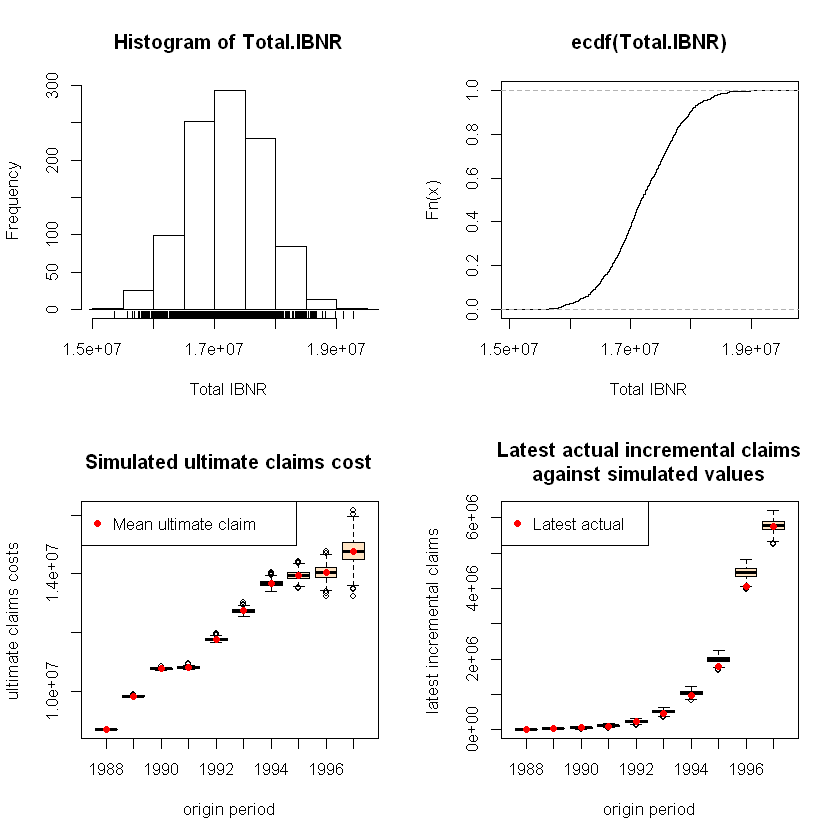

In [55]:
plot(BootCL)

Quantiles of the bootstrap IBNR can be calculated via the quantile function:

In [56]:
quantile(BootCL, c(0.75,0.95,0.99, 0.995))

,IBNR 75%,IBNR 95%,IBNR 99%,IBNR 99.5%
1988,0.00,0.00,0.00,0.00
1989,14111.36,32349.65,46520.17,61268.07
1990,52032.47,77880.19,100040.90,110227.29
1991,114088.00,152401.23,177383.58,192165.99
1992,253383.80,307203.25,343909.90,357226.12
1993,538444.05,611961.60,681011.85,698248.96
1994,1134057.53,1235434.09,1310373.73,1336274.21
1995,2244717.81,2391691.38,2512371.42,2551291.26
1996,4306079.72,4521866.45,4674233.22,4715349.45
1997,9313683.41,9722587.99,9956682.95,10102010.39


The distribution of the IBNR appears to follow a log-normal distribution, so let’s fit it:

ERROR: Error in fitdistr(BootCL$IBNR.Totals[BootCL$IBNR.Totals > 0], "lognormal"): 沒有這個函數 "fitdistr"


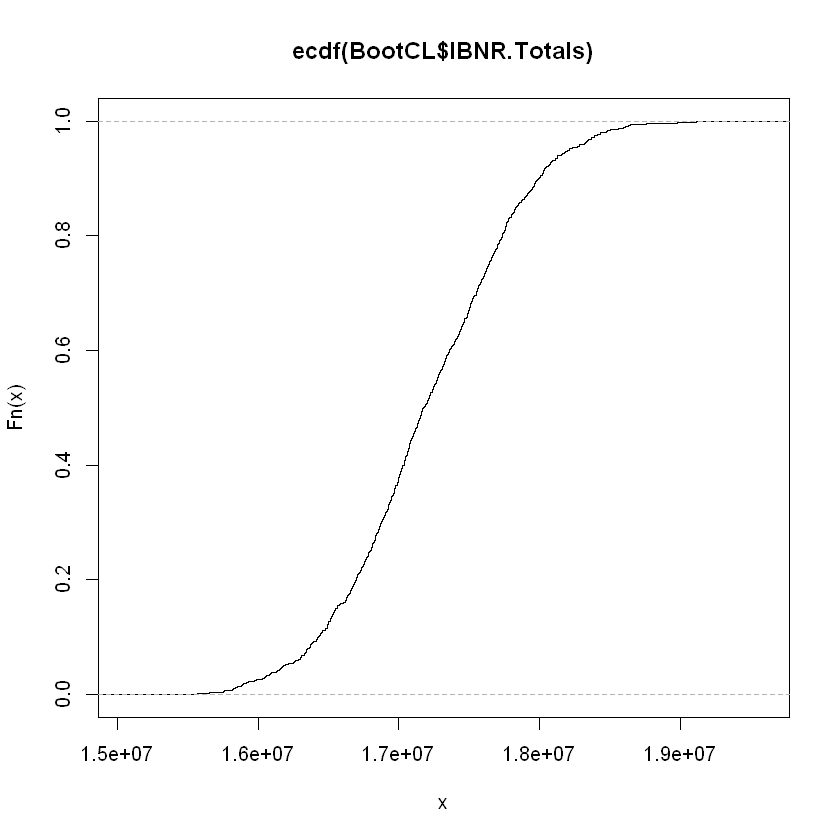

In [57]:
plot(ecdf(BootCL$IBNR.Totals))
fit <- fitdistr(BootCL$IBNR.Totals[BootCL$IBNR.Totals>0], "lognormal")  # fit a log-normal distribution
fit